In [1]:
import pandas as pd

# Define the file path
file_path = "FaizansLLM/06_finetuning/spam.csv"  # Relative path since the notebook is in the same directory

# Read the CSV file
df = pd.read_csv(file_path, encoding= 'latin1')

# Display the first few rows
df.head()
df = df[['v1', 'v2']]
df.columns = ["Label", "Text"]
df.head()



,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [3]:
def create_balanced_dataset(df):
    num_spam =  df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam , random_state=123
    )

    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [4]:
balanced_df["Label"] = balanced_df["Label"].map({'ham' : 0, 'spam' : 1})
balanced_df

,Label,Text
4307,0,Ha ha - had popped down to the loo when you he...
4138,0,Ever green quote ever told by Jerry in cartoon...
4831,0,Rats. Hey did u ever vote for the next themes?
4461,0,"Sorry I flaked last night, shit's seriously go..."
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [5]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac) 

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [6]:
import tiktoken 
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [7]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [8]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None, 
    tokenizer=tokenizer
)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length, 
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length, 
    tokenizer=tokenizer
)

In [9]:
print(train_dataset.max_length)
print(val_dataset.max_length)
print(test_dataset.max_length)
# max_length can be upto 1024 tokens or upto context length of the model. 

103
103
103


In [10]:
# Dataloader 
from torch.utils.data import DataLoader

num_workers = 0 
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_laoder = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

In [11]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimesnsion : ", input_batch.shape)
print("target batch dimesnsion : ", target_batch.shape)

Input batch dimesnsion :  torch.Size([8, 103])
target batch dimesnsion :  torch.Size([8])


In [12]:
print(f'{len(train_loader)} training batches')
print(f'{len(val_laoder)} val batches')
print(f'{len(test_loader)} test batches')

130 training batches
18 val batches
37 test batches


In [13]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [14]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

print("CHOOSE_MODEL:", CHOOSE_MODEL)
print("Extracted Model Size:", model_size)


CHOOSE_MODEL: gpt2-small (124M)
Extracted Model Size: 124M


In [15]:
### Loading Pre-trained GPT
from gpt_download import download_and_load_gpt2
from LLMcore import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)


model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2025-02-20 02:55:07.800283: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 02:55:08.187708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 02:55:08.371004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 02:55:08.373058: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 02:55:08.737864: I tensorflow/core/platform/cpu_feature_gua

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [16]:
from LLMcore import generate_text_simple, text_to_token_ids, token_ids_to_text, generate

In [17]:
text_1 = "Every effort moves you "
token_ids = generate_text_simple(
model=model,
idx=text_to_token_ids(text_1, tokenizer),
max_new_tokens=6,
context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you  to the next step.


In [18]:
text_2 = (
"Is the following text 'spam'? Answer with 'yes' or 'no':"
" 'You are a winner you have been specially"
" selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate(
model=model,
idx=text_to_token_ids(text_2, tokenizer),
max_new_tokens=23,
context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
BASE_CONFIG['emb_dim']

768

In [21]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

In [22]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [23]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs : ", inputs)
print("Inputs Dimensions :", inputs.shape)

Inputs :  tensor([[5211,  345,  423,  640]])
Inputs Dimensions : torch.Size([1, 4])


In [24]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs :", outputs)
print("Outputs shape :", outputs.shape)

Outputs : tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs shape : torch.Size([1, 4, 2])


###  Calculating loss and estimating accuracy

In [25]:
print("Last output token :", outputs[: , -1 , :])

Last output token : tensor([[-3.5983,  3.9902]])


In [26]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("class label : ", label.item())

class label :  1


In [27]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
                predicted_labels = torch.argmax(logits, dim=-1)
                num_examples += predicted_labels.shape[0]
                correct_predictions += ((predicted_labels == target_batch).sum().item()
                )
        else:
            break
    return correct_predictions / num_examples

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)

val_accuracy = calc_accuracy_loader(
    val_laoder, model, device, num_batches=10
)

test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 53.75%
Test accuracy: 50.00%


In [29]:
def calc_loss_batch(input_batch, target_batch, model, device):
    logits = model(input_batch)[:, -1, :]   # last token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [30]:
def  calc_loss_loader(data_loader, model, device, num_batches):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i , (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else :
            break
    
    return total_loss / num_batches

In [31]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_laoder, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 3.199
Validation loss: 2.419
Test loss: 2.577


In [32]:
def evaluate_model(model, train_loader, val_laoder, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )

        val_loss = calc_loss_loader(
            val_laoder, model, device, num_batches=eval_iter
        )

    model.train()
    return train_loss, val_loss

In [33]:
def train_classifier_simple(model, train_loader, val_laoder, opitmizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], [] 
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            opitmizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            opitmizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_laoder, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch +1} (Step {global_step:06d}) : "
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss:.3f}")
                
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_laoder, model, device, num_batches=eval_iter)

        print(f"Training accuracy : {train_accuracy*100:.2f} % | ", end=" " )
        print(f"Validation accuracy : {val_accuracy*100:.2f} % ")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [34]:
import time 
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 2

train_losses , val_losses, train_accs, val_accs , examples_seen = train_classifier_simple(model, train_loader, val_laoder, optimizer, device, num_epochs, eval_freq=50, eval_iter=5)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("training completed in {execution_time_minutes:.2f} minutes")

Ep 1 (Step 000000) : Train loss 2.141,Val loss 2.874
Ep 1 (Step 000050) : Train loss 0.594,Val loss 0.582
Ep 1 (Step 000100) : Train loss 0.493,Val loss 0.538
Training accuracy : 77.50 % |  Validation accuracy : 80.00 % 
Ep 2 (Step 000150) : Train loss 0.540,Val loss 0.496
Ep 2 (Step 000200) : Train loss 0.349,Val loss 0.326
Ep 2 (Step 000250) : Train loss 0.405,Val loss 0.261
Training accuracy : 90.00 % |  Validation accuracy : 90.00 % 
training completed in {execution_time_minutes:.2f} minutes


In [35]:
import time 
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 1

train_losses , val_losses, train_accs, val_accs , examples_seen = train_classifier_simple(model, train_loader, val_laoder, optimizer, device, num_epochs, eval_freq=50, eval_iter=5)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print("training completed in {execution_time_minutes:.2f} minutes")

Ep 1 (Step 000000) : Train loss 0.432,Val loss 0.167
Ep 1 (Step 000050) : Train loss 0.176,Val loss 0.122
Ep 1 (Step 000100) : Train loss 0.093,Val loss 0.160
Training accuracy : 87.50 % |  Validation accuracy : 100.00 % 
training completed in {execution_time_minutes:.2f} minutes


In [36]:
print(f"training completed in {execution_time_minutes:.2f} minutes")

training completed in 2.47 minutes


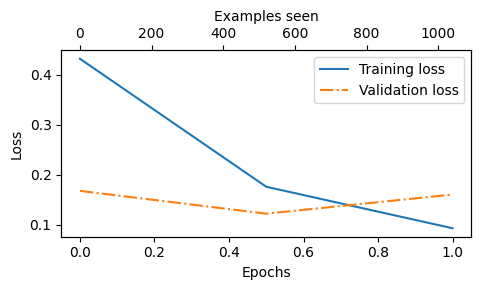

In [37]:
import matplotlib.pyplot as plt
def plot_values(
epochs_seen, examples_seen, train_values, val_values,
label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
    epochs_seen, val_values, linestyle="-.",
    label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [38]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_laoder, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 94.81%
Validation accuracy: 96.53%
Test accuracy: 92.57%
